## Test the splitting approach performance

In [1]:
import sys, os

sys.path.append("../spectraltree")

import copy
import numpy as np
import utils
import generation
import reconstruct_tree
import dendropy
import scipy
import time
from itertools import product
import matplotlib.pyplot as plt
import pandas as pd
import pickle

from dendropy.model.discrete import simulate_discrete_chars, Jc69, Hky85
from dendropy.calculate.treecompare import symmetric_difference
from sklearn.decomposition import TruncatedSVD

def HKY_similarity_matrix(observations, classes=None, verbose = False):
    m, N = observations.shape
    if classes is None:
        classes = np.unique(observations)
    k = len(classes)
    # From Tamura, K., and M. Nei. 1993
    # for each pair of sequences, 
    # 1. estimate the average base frequency for pairs of sequences
    # 2. compute purine transition proportion P1 (A <-> G)
    # 3. compute pyrimidine transition proportion P2 (T <-> C)
    # 3. compute transversion proportion Q (A <-> C, A <-> T, G <-> C, G <-> T)

    if verbose: print("Computing the average base frequency for each pair of sequences...")
    g = {}
    for x in classes:
        obs_x = observations == x
        g[x] = np.array([np.mean(np.hstack([a, b])) for a, b in product(obs_x, repeat = 2)]).reshape((m, m))
    
    g["R"] = g["A"] + g["G"]
    g["Y"] = g["T"] + g["C"]
    
    # compute transition and transversion proportion
    if verbose: print("Computing transition and transversion proportion for each pair of sequences...")
    P = {}
    for i, x in enumerate(classes):
        other_classes = np.delete(classes, i)
        for y in other_classes:
            P_x_y = np.array([np.mean(np.logical_and(a == x, b == y)) for a, b in product(observations, repeat = 2)]).reshape((m, m))
            P[x + y] = P_x_y
            
    P_1 = P['AG'] + P["GA"]
    P_2 = P['CT'] + P['TC']
    Q = P['AC'] + P['CA'] + P['AT'] + P['TA'] +\
        P['GC'] + P['CG'] + P['GT'] + P['TG']

    # compute the similarity (formula 7)
    if verbose: print("Computing similarity matrix")
    R = (1 - g["R"]/(2 * g["A"] * g["G"]) * P_1 - 1 / (2 * g["R"]) * Q)
    Y = (1 - g["Y"]/(2 * g["T"] * g["C"]) * P_2 - 1 / (2 * g["Y"]) * Q)
    T = (1 - 1/(2 * g["R"] * g["Y"]) * Q)
    S = np.sign(R) * (np.abs(R))**(2 * g["A"] * g["G"] / g["R"])
    S += np.sign(Y) * (np.abs(Y))**(2 * g["T"] * g["C"] / g["Y"])
    S += np.sign(T) * (np.abs(T))**(2 * (g["R"] * g["Y"] - g["A"] * g["G"] * g["Y"] / g["R"] - g["T"] * g["C"] * g["R"] / g["Y"]))

    return S

def check_is_bipartition(tree, bool_partition):
    bipartitions = [str(x)[::-1] for x in tree.encode_bipartitions()]
    partition_1 = "".join(list(bool_partition.astype('int').astype('str')))
    partition_2 = "".join(list((1 - bool_partition).astype('int').astype('str')))
    is_bipartition = (partition_1 in bipartitions) or (partition_2 in bipartitions)
    return is_bipartition

In [2]:
tree_path = "../../spec_tree/data/skygrid_J2.newick"
fasta_path = "../../spec_tree/data/H3N2_NewYork.fasta"

H3N2_tree = dendropy.Tree.get(path=tree_path, schema="newick")

In [ ]:
B = 50
N = [20, 50, 100, 1000]
mean_is_bipartition = []

for n in N:
    print(n)
    bipartitions = []
    start_time = time.time()
    for b in range(B):
        print(b)
        data_HKY = simulate_discrete_chars(n, H3N2_tree, Hky85(kappa = 2), mutation_rate=0.1)
        ch_list = list()
        for t in data_HKY.taxon_namespace: 
            ch_list.append([x.symbol for x in data_HKY[t]])
        ch_arr = np.array(ch_list)
        
        HKY_sim = HKY_similarity_matrix(ch_arr)
        _, eigvec = np.linalg.eigh(HKY_sim)
        partition = reconstruct_tree.partition_taxa(eigvec[:,-2], HKY_sim, 1)
        is_bipartition = check_is_bipartition(H3N2_tree, partition)
        bipartitions.append(int(is_bipartition))
    runtime = time.time() - start_time
    print("--- %s seconds ---" % runtime)

    mean_is_bipartition.append(np.mean(bipartitions))

metrics = pd.DataFrame({"N": N, "valid partition freq": mean_is_bipartition})
metrics.to_csv("/gpfs/ysm/project/kleinstein/mw957/repos/spec_tree/script/split_metrics.csv")

In [2]:
metrics = pd.read_csv("/gpfs/ysm/project/kleinstein/mw957/repos/spec_tree/script/split_metrics.csv")
metrics.iloc[:,1:3]

,N,valid partition freq
0,50,0.66
1,100,0.82
2,400,1.00
3,600,1.00
4,800,1.00
5,1000,1.00


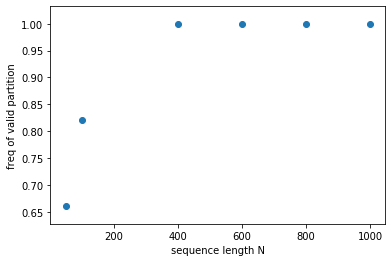

In [3]:
plt.scatter(metrics.N, metrics["valid partition freq"])
plt.xlabel("sequence length N")
plt.ylabel("freq of valid partition")
plt.show()

## Test the rooting approach

In [4]:
all_bipartitions = np.array([str(x)[::-1] for x in H3N2_tree.encode_bipartitions()][0:-1])

taxon_namespace_label = np.array([x.label for x in H3N2_tree.taxon_namespace])

def to_bool(partition_str):
    return np.array(list(partition_str)) == '1'

def min_partition_size(bipartition_encoding):
    n_ones = np.sum(np.array(list(bipartition_encoding)) == '1')
    n_zeros = np.sum(np.array(list(bipartition_encoding)) == '0')
    return(min(n_ones, n_zeros))

min_bipar = np.array([min_partition_size(x) for x in all_bipartitions])
filtered_bipar = all_bipartitions[np.where(min_bipar > 50)[0]]

In [5]:
len(all_bipartitions)

1127

In [6]:
len(filtered_bipar)

43

43 out of 1127 bipartitions have minimum partition size > 50. Tested all 43 bipartitions. 

In [ ]:
N = [50, 100, 400, 600, 800, 1000]
Ns = []
par1s = []
par2s = []
RFs = []
F1s = []
rts = []

for n in N:
    print(n)
    data_HKY = simulate_discrete_chars(n, H3N2_tree, Hky85(kappa = 2), mutation_rate=0.1)
    ch_list = list()
    for t in data_HKY.taxon_namespace: 
        ch_list.append([x.symbol for x in data_HKY[t]])
    ch_arr = np.array(ch_list)
    HKY_sim = HKY_similarity_matrix(ch_arr)
    
    for partition in filtered_bipar:
        partition = to_bool(partition)
        par1_size = np.sum(partition)
        par2_size = np.sum(np.logical_not(partition))
        print("Partition size: ", par1_size, " vs ", par2_size)
        left_namespace = list(taxon_namespace_label[np.where(partition)[0]])
        left_taxa = dendropy.TaxonNamespace([taxon for taxon in H3N2_tree.taxon_namespace
            if taxon.label in left_namespace])

        T_left = copy.deepcopy(H3N2_tree).extract_tree_with_taxa_labels(labels = left_namespace)
        T_left.purge_taxon_namespace()
        s = T_left.as_string(schema = "newick")
        T_left = dendropy.Tree.get(data=s, schema="newick", taxon_namespace = left_taxa)
        right_namespace = list(taxon_namespace_label[np.where(np.logical_not(partition))[0]])
        right_taxa = dendropy.TaxonNamespace([taxon for taxon in H3N2_tree.taxon_namespace
            if taxon.label in right_namespace])
        T_right = copy.deepcopy(H3N2_tree).extract_tree_with_taxa_labels(labels = right_namespace)
        T_right.purge_taxon_namespace()
        s = T_right.as_string(schema = "newick")
        T_right = dendropy.Tree.get(data=s,
        schema="newick", taxon_namespace = right_taxa)
        
        start_time = time.time()
        joined_tree = reconstruct_tree.join_trees_with_spectral_root_finding(
            HKY_sim, T_left, T_right, taxon_namespace = H3N2_tree.taxon_namespace)
        runtime = time.time() - start_time
        
        RF,F1 = reconstruct_tree.compare_trees(joined_tree, H3N2_tree)
        
        Ns.append(n)
        par1s.append(par1_size)
        par2s.append(par2_size)
        RFs.append(RF)
        F1s.append(F1)
        rts.append(runtime)
        
perf_metrics = pd.DataFrame({'seqlength': Ns, 'par1_size': par1s, 'par2_size': par2s, 
                             'RF': RFs, "F1": F1s, "runtime": rts})
perf_metrics.to_csv("/gpfs/ysm/project/kleinstein/mw957/repos/spec_tree/script/rooting_metrics_normalized.csv")

In [3]:
perf_metrics = pd.read_csv("/gpfs/ysm/project/kleinstein/mw957/repos/spec_tree/script/rooting_metrics.csv")
perf_metrics = perf_metrics.drop(columns = "Unnamed: 0")

In [5]:
perf_metrics_normed = pd.read_csv("/gpfs/ysm/project/kleinstein/mw957/repos/spec_tree/script/rooting_metrics_normalized.csv")
perf_metrics_normed = perf_metrics_normed.drop(columns = "Unnamed: 0")

## partition size distribution

In [18]:
min_par_size = perf_metrics.loc[:, ["par1_size", "par2_size"]].min(axis = 1)

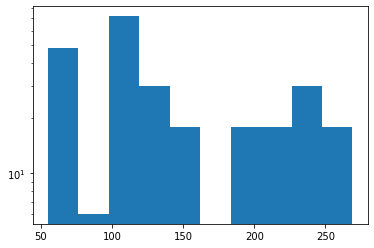

In [19]:
_ = plt.hist(min_par_size, log = True)

performance metrics for merging a partition with only a single node with the rest

In [11]:
perf_metrics.\
  drop(columns = ["par1_size", "par2_size", "F1"]).groupby(["seqlength"]).agg(["min", "max", "mean", "std"])

RF                         runtime                                
          min max median        std       min        max     median       std
seqlength                                                                    
50          8  62     22  16.919063  8.914303  12.489810  10.495854  1.145755
100        10  72     26  15.555424  9.001953  12.563638  10.391983  1.148289
400         0  48     20  10.847172  8.907304  12.582769  10.459752  1.168563
600         4  48     16  10.724993  8.914942  12.546468  10.363778  1.167978
800         4  46     20  10.763747  8.960029  12.613173  10.510476  1.184875
1000        4  44     14  10.537283  8.946734  12.528035  10.402806  1.173976

In [16]:
perf_metrics_normed.\
  drop(columns = ["par1_size", "par2_size", "F1"]).groupby(["seqlength"]).agg(["min", "max", "mean", "std"])

RF                             runtime                        \
          min max       mean        std       min        max       mean   
seqlength                                                                 
50          2  54  37.116279  14.377908  9.655290  13.101711  11.464496   
100        14  74  41.720930  20.658592  9.775056  13.302094  11.562207   
400         6  40  23.627907   9.281377  9.725750  13.188796  11.533988   
600         4  50  20.930233  12.300591  9.875435  13.432615  11.678574   
800         4  58  22.418605  12.832683  9.860095  13.332609  11.637845   
1000        2  36  16.000000   8.406347  9.572313  13.435120  11.513642   

                     
                std  
seqlength            
50         1.101388  
100        1.133300  
400        1.131945  
600        1.149267  
800        1.143191  
1000       1.059607

## Histogram of RF

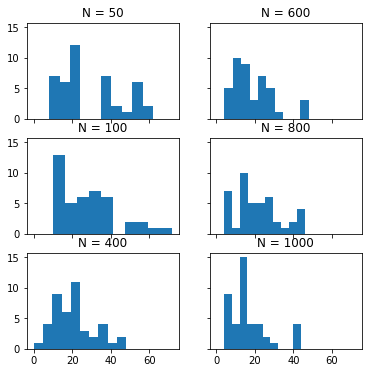

In [44]:
fig, axes = plt.subplots(3, 2, figsize = (6, 6), sharex = True, sharey = True)
for i, seqlen in enumerate(np.unique(perf_metrics.seqlength)):
    #print("seqlength:", i)
    perf_metrics_sub = perf_metrics.loc[(perf_metrics.seqlength == seqlen),:]
    axes[i%3, i//3].hist(perf_metrics_sub.RF)
    axes[i%3, i//3].set_title("N = " + str(seqlen))

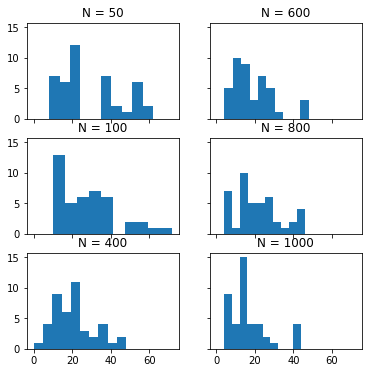

In [10]:
fig, axes = plt.subplots(3, 2, figsize = (6, 6), sharex = True, sharey = True)
for i, seqlen in enumerate(np.unique(perf_metrics.seqlength)):
    #print("seqlength:", i)
    perf_metrics_sub = perf_metrics.loc[(perf_metrics_normed.seqlength == seqlen),:]
    axes[i%3, i//3].hist(perf_metrics_sub.RF)
    axes[i%3, i//3].set_title("N = " + str(seqlen))

## Examining the distribution of eigenvalues

1. Compute a submatrix S(A,B) of some random legitimate partition of the tree to A and B. Let |A|,|B| be the corresponding subset size of A and B.
The submatrix should be computed with a long sequence (say 10^5 or if possible 10^6) and for short sequences of length 10^3 and 500. Let S^ast be the
submatrix computed with a long sequence and S^til be the matrix computed with the short sequence
2. Compute the singular values of (S^ast - S^til)  (say lambda_1,.... lambda_p) where p is equal to the minimum of |A|,|B|
3. plot a histogram of lambda_i^2, together with the Marchenko Pastur distribution with parameters |A| and |B|
See example here:
http://www.bnikolic.co.uk/blog/python/2019/11/28/marchenko-pastur.html

In [7]:
test_partition = filtered_bipar[0]
partition = to_bool(test_partition)[::-1]
A_size = np.sum(partition)
B_size = np.sum(np.logical_not(partition))

In [8]:
def simulate_sim_mat(N, tree):
    data_HKY = simulate_discrete_chars(N, tree, Hky85(kappa = 2), mutation_rate=0.1)
    ch_list = list()
    for t in data_HKY.taxon_namespace: 
        ch_list.append([x.symbol for x in data_HKY[t]])
    ch_arr = np.array(ch_list)
    HKY_sim = HKY_similarity_matrix(ch_arr)
    return(HKY_sim)

In [9]:
print(A_size, B_size)

66 499


In [10]:
p = min(A_size, B_size)
N_long = 10**5
N_short = [500, 1000]

In [14]:
S_til_1 = simulate_sim_mat(N_short[0], H3N2_tree)
with open("/gpfs/ysm/project/kleinstein/mw957/repos/spec_tree/script/sim_S_500.pkl", "wb") as f:
    pickle.dump(S_til_1, file =f)

In [11]:
with open("../../spec_tree/script/sim_S_500.pkl", "rb") as f:
    S_til_1 = pickle.load(f)

In [21]:
S_til_2 = simulate_sim_mat(N_short[1], H3N2_tree)
with open("/gpfs/ysm/project/kleinstein/mw957/repos/spec_tree/script/sim_S_1000.pkl", "wb") as f:
    pickle.dump(S_til_2, file =f)

In [12]:
with open("../../spec_tree/script/sim_S_1000.pkl", "rb") as f:
    S_til_2 = pickle.load(f)

In [29]:
S_ast = simulate_sim_mat(N_long, H3N2_tree)
with open("/gpfs/ysm/project/kleinstein/mw957/repos/spec_tree/script/sim_S_100000.pkl", "wb") as f:
    pickle.dump(S_ast, file =f)

In [13]:
with open("../../spec_tree/script/sim_S_100000.pkl", "rb") as f:
    S_ast = pickle.load(f)

In [14]:
# difference between similarity matrix
S_diff_1 = S_ast - S_til_1
S_diff_2 = S_ast - S_til_2

S_AB_1 = S_diff_1[partition, :][:, ~partition]
S_AB_2 = S_diff_2[partition, :][:, ~partition]

In [22]:
# compute signular values
SVD2_OBJ = TruncatedSVD(n_components=p)
sigmas_1 = SVD2_OBJ.fit(S_AB_1).singular_values_
sigmas_2 = SVD2_OBJ.fit(S_AB_2).singular_values_

In [16]:
sigmas = [sigmas_1, sigmas_2]

In [17]:
# http://www.bnikolic.co.uk/blog/python/2019/11/28/marchenko-pastur.html
def marchpast(l, g):
    """
    Marchenko-Pastur distribution
    Arguments:
    - l: the range you want to compute the distribution
    - g: n/p 
    """
    def m0(a):
        "Element wise maximum of (a,0)"
        return np.maximum(a, np.zeros_like(a))
    gplus=(1+g**0.5)**2
    gminus=(1-g**0.5)**2
    return np.sqrt(  m0(gplus  - l) *  m0(l- gminus)) / ( 2*np.pi*g*l)

In [18]:
g = A_size/B_size
g

0.13226452905811623

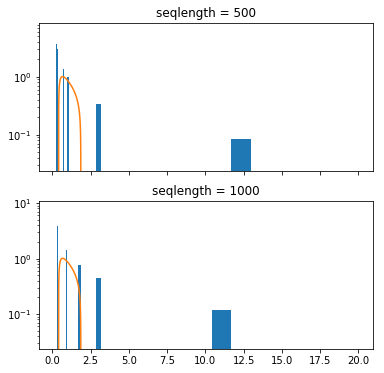

In [24]:
fig, axes = plt.subplots(2, 1, figsize = (6, 6), sharex = True)
for i, n in enumerate(N_short):
    nn, bb, patches = axes[i].hist(sigmas[i].ravel()**2, 
                                   bins = np.logspace(np.log10(0.1),np.log10(20), 50), 
                                   density=True, log = True)
    x = np.arange(bb[0], bb[-1], 0.003)
    axes[i].plot(x, marchpast(x, g))
    axes[i].set_ylim(top=nn[1:].max() * 1.1)
    axes[i].set_title("seqlength = " + str(n))